In [76]:
import numpy as np
import pandas as pd
import torch
from PIL import Image, ExifTags
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os
import json

In [77]:
!nvidia-smi

Tue Jun 20 01:03:02 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 530.41.03    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-32GB            On | 00000000:58:00.0 Off |                    0 |
| N/A   28C    P0               27W / 250W|      4MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [78]:
torch.cuda.is_available()

True

In [79]:
device = "cuda"

The task
Your tasks for training and deploying a simple object detector to detect litter and trash are:
1. Extract object proposals for all the images of the dataset (e.g. Selecting Search, Edge Boxes, etc). Note that you may have to resize the images before you run SS for better efficiency.
2. Finetune a convolutional neural network to classify object proposals.
3. Apply the model on the test images and implement non-maximum sup- presion and Intersection over Union (IoU).
4. Evaluate the object detection performance using standard metrics.
Optional tasks:
1. Improve the simple model above by adding a bounding-box regression output that improves the detection performance.
2. Improve the efficiency of the simple model (i.e., ROI pooling layer inspired by Fast RCNN).
3. Implement a Convolutional Neural Network that is trained to generate generic object proposals to replace the object proposal algorithm (i.e., Region Proposal Network inspired by Faster RCNN).
The goal of the project is not to simply apply an object detection model that you find online, but rather to build step-by-step a simple model by yourself. After that, feel free to improve this model by following the suggestions in the optional tasks above or to even apply a single-stage object detector.

In [80]:
%matplotlib inline

## Misc init

In [81]:
# DRIVE dataset
!( \
cd ..; \
cd ..; \
cd ..; \
cd ..; \
cd ..; \
cd ..; \
cd ..; \
cd ..; \
cd dtu; \
cd datasets1; \
cd 02514; \
cd data_wastedetection; \
ls; \
)

all_image_urls.csv  batch_10  batch_13	batch_2  batch_5  batch_8
annotations.json    batch_11  batch_14	batch_3  batch_6  batch_9
batch_1		    batch_12  batch_15	batch_4  batch_7


In [82]:
DATASET_PATH = '../../../../../../../../dtu/datasets1/02514/data_wastedetection'
ANNOTATIONS_FILE_PATH = DATASET_PATH + '/' + 'annotations.json'

In [83]:
# Obtain Exif EXIF_KEY_ORIENTATION tag code
EXIF_KEY_ORIENTATION = None
for key in ExifTags.TAGS.keys():
    if ExifTags.TAGS[key] == 'Orientation':
        EXIF_KEY_ORIENTATION = key
        break
assert EXIF_KEY_ORIENTATION

In [84]:
coco_annotations = COCO(ANNOTATIONS_FILE_PATH)

loading annotations into memory...
Done (t=0.26s)
creating index...
index created!


In [85]:
with open(ANNOTATIONS_FILE_PATH, 'r') as f:
    dataset = json.loads(f.read())

In [86]:
# create IDs for super categories
SUPER_CATEGORIES = set()
for sub_category_d in dataset["categories"]:
    superCategoryName = sub_category_d["supercategory"]
    SUPER_CATEGORIES.add(superCategoryName)
SUPER_CATEGORIES_ID_TO_NAME = {id:name for id, name in enumerate(SUPER_CATEGORIES)}
SUPER_CATEGORIES_NAME_TO_ID = {name:id for id, name in enumerate(SUPER_CATEGORIES)}

# create SUB -> SUPER dictionary
SUB_ID_TO_SUPER_ID = {}
for sub_category_d in dataset["categories"]:
    superCategoryName = sub_category_d["supercategory"]
    subCategoryId = sub_category_d["id"]
    subCategoryName = sub_category_d["name"]
    # add super category id to sub 
    SUB_ID_TO_SUPER_ID[subCategoryId] = SUPER_CATEGORIES_NAME_TO_ID[superCategoryName]


In [87]:
class _BoundingBox:
    def __init__(self, d):
        self.x,self.y,self.w,self.h = d["bbox"]
        self.xywh = d["bbox"]
        self.subCategoryId = d["category_id"]
        self.superCategoryId = SUB_ID_TO_SUPER_ID[self.subCategoryId]
        self.superCategoryName = SUPER_CATEGORIES_ID_TO_NAME[self.superCategoryId]
        self.label = superCategoryName
        self.imageId = d["image_id"]
        
        

In [88]:
class _Image:
    def __init__(self, d, coco_annotations):
        self.id = d["id"]
        self.width = d["width"]
        self.height = d["height"]
        self.path = d["file_name"]
        
        # get image - rotate if necessary
        _image = Image.open(DATASET_PATH + '/' + self.path)
        if _image._getexif():
            exif = dict(_image._getexif().items())
            if EXIF_KEY_ORIENTATION in exif:
                if exif[EXIF_KEY_ORIENTATION] == 3: _image = _image.rotate(180,expand=True)
                elif exif[EXIF_KEY_ORIENTATION] == 6: _image = _image.rotate(270,expand=True)
                elif exif[EXIF_KEY_ORIENTATION] == 8: _image = _image.rotate(90,expand=True)
        self.image = np.array(_image)
        
        # get bounding boxes 
        annotations = coco_annotations.loadAnns(coco_annotations.getAnnIds(imgIds=self.id, catIds=[], iscrowd=None))
        self.boundingBoxes = [_BoundingBox(object_d) for object_d in annotations]
    
    def imshow(self, annotations=True):
        fig,ax = plt.subplots(1)
        plt.axis('off')
        plt.imshow(self.image)
        for boundingBox in self.boundingBoxes:
            x,y,w,h = boundingBox.xywh
            rect = Rectangle((x,y),w,h,linewidth=2,edgecolor="green",
                         facecolor='none', alpha=0.7, linestyle = '--')
            ax.add_patch(rect)
            # add self.label to upper left corner of rect
            plt.text(x,y,f"{boundingBox.superCategoryName}", color="white", size=int(self.image.shape[1]/250))
        plt.show()
        

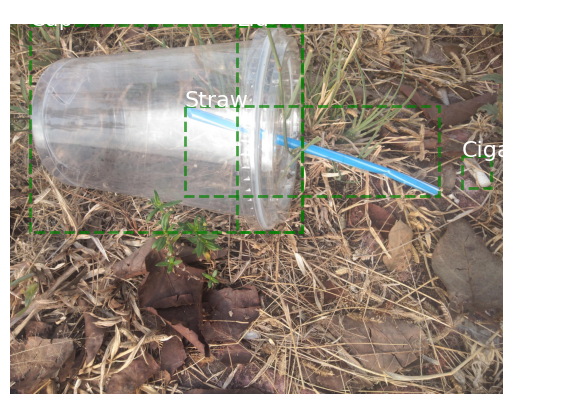

In [89]:
# create instance of _Image and plot

d_img = dataset["images"][np.random.randint(0,1000)]
image = _Image(d_img, coco_annotations)
image.imshow()

In [90]:
# custom torch dataset object
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset["images"])

    def __getitem__(self, idx):
        d = self.dataset["images"][idx]
        Image = _Image(d, coco_annotations)
        if self.transform: Image.image = self.transform(Image.image) #TODO transform bbs
        return Image

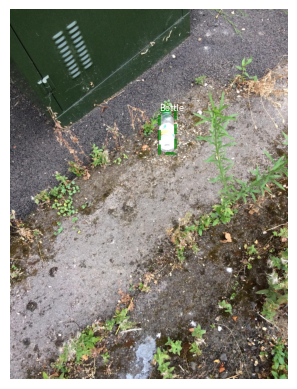

In [97]:
_dataset = Dataset(dataset)
_dataset[np.random.randint(0,100)].imshow()